#Introducción
blablbabla

    photo

# 1. Importando módulos y data

## 1.1 Importar módulos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import plotly.express as px
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

## 1.2 Importamos data

Este conjunto de datos estaba dividido en un total de 7 archivos. Aquel llamado "listings", contiene una descripción general recomendada para la visualización de datos. El único identificador del data set se encuentra en dicho archivo.
La actualización de este data set incluye 18126 listings de Copenague, el 24 de Septiembre de 2023. 


In [2]:
#Reading data
listings = pd.read_csv("/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/input/listings.csv", index_col= "id")
listings_details = pd.read_csv("/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/input/listings.csv.gz", index_col= "id", low_memory=False)

calendar = pd.read_csv("/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/input/calendar.csv.gz", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/input/reviews.csv.gz", parse_dates=['date'])

In [3]:
print(listings.shape)

(18126, 17)


"Listings" contiene 17 variables per "listing", además del ID.

In [4]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [5]:
print(listings_details.shape)

(18126, 74)


In [6]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

El archivo listados_detalles contiene un total de 74 variables. No vamos a usar todas la variables, se juntan selectivamente una serie de variables que parecen útiles para este EDA.

In [3]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "neighborhood_overview"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18126 entries, 26057 to 986339893079082661
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            18126 non-null  object 
 1   host_id                         18126 non-null  int64  
 2   host_name                       18125 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   18126 non-null  object 
 5   latitude                        18126 non-null  float64
 6   longitude                       18126 non-null  float64
 7   room_type                       18126 non-null  object 
 8   price                           18126 non-null  int64  
 9   minimum_nights                  18126 non-null  int64  
 10  number_of_reviews               18126 non-null  int64  
 11  last_review                     15939 non-null  object 
 12  reviews_per_mon

Vemos que el grupo_vecindario es inútil en Copenhague, ya que contiene cero objetos no nulos. A continuación, nos deshacemos de esta variable y mostramos el encabezado del marco de datos con el que vamos a trabajar.

In [4]:
listings = listings.drop(columns=['neighbourhood_group','license'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

name  host_id host_name  \
id                                                                             
26057   Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...   109777      Kari   
26473   Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...   112210     Julia   
29118   Rental unit in Copenhagen · ★4.85 · 1 bedroom ...   125230      Nana   
31094   Condo in Copenhagen · ★4.88 · 4 bedrooms · 2 b...   129976      Ebbe   
113508  Rental unit in Frederiksberg · ★4.96 · 2 bedro...   577366    Ronnie   

                    neighbourhood   latitude  longitude        room_type  \
id                                                                         
26057                    Indre By  55.693070  12.576490  Entire home/apt   
26473                    Indre By  55.676020  12.575400  Entire home/apt   
29118   Vesterbro-Kongens Enghave  55.670230  12.555040  Entire home/apt   
31094   Vesterbro-Kongens Enghave  55.666602  12.555283  Entire home/apt   
113508              Frederiksberg  55.677570  12.556080  Entire home/apt   

        price  minimum_nights  number_of_reviews  ...  \
id                                                ...   
26057    2900               5                 59  ...   
26473    3350               3                338  ...   
29118     725               7                 26  ...   
31094    1954               3                 19  ...   
113508   3536               2                 50  ...   

       review_scores_communication  review_scores_checkin  \
id                                                          
26057                         4.86                   4.93   
26473                         4.73                   4.80   
29118                         5.00                   4.88   
31094                         4.82                   4.87   
113508                        5.00                   4.98   

        review_scores_rating  maximum_nights  \
id                                             
26057                   4.91            1125   
26473                   4.55              31   
29118                   4.85              14   
31094                   4.88              10   
113508                  4.96             730   

                                listing_url host_is_superhost  \
id                                                              
26057    https://www.airbnb.com/rooms/26057                 f   
26473    https://www.airbnb.com/rooms/26473                 t   
29118    https://www.airbnb.com/rooms/29118                 f   
31094    https://www.airbnb.com/rooms/31094                 f   
113508  https://www.airbnb.com/rooms/113508                 t   

                                               host_about host_response_time  \
id                                                                             
26057   We are a family with 2 children, and living in...     within an hour   
26473   Active young woman, started as an expat in Cop...     within an hour   
29118   I have a Master of Arts in Musicology and I wo...     within an hour   
31094   Hi and welcome. My name is Ebbe, I am a medica...                NaN   
113508  Welcome to our profile. We love to travel and ...     within an hour   

        host_response_rate                              neighborhood_overview  
id                                                                             
26057                100.0  The neighborhood is the most famous one and th...  
26473                100.0                                                NaN  
29118                100.0                                                NaN  
31094                  NaN  What else is nearby?<br />To be honest, We thi...  
113508               100.0  You will be in the western part of Copenhagen ...  

[5 rows x 32 columns]

La variable "price" está expresada en dólares. Para mayor comodidad la pasaremos a euros y crearemos una nueva columna con el cambio a coronas danesas, por si es necesaria en algún momemnto.
También se importará el df como CSV para poder utilizarlo en otras plataformas.

In [5]:
#Tasa de conversión
dolar_to_euro=0.94
dolar_to_crown=7

#aplicar la conversión de dólar a euro
listings['price'] = listings['price'] * dolar_to_euro
listings['price_dcrown']=listings['price'] * dolar_to_crown

listings.head(2)

name  host_id host_name  \
id                                                                            
26057  Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...   109777      Kari   
26473  Townhouse in Copenhagen · ★4.55 · 6 bedrooms ·...   112210     Julia   

      neighbourhood  latitude  longitude        room_type   price  \
id                                                                  
26057      Indre By  55.69307   12.57649  Entire home/apt  2726.0   
26473      Indre By  55.67602   12.57540  Entire home/apt  3149.0   

       minimum_nights  number_of_reviews  ... review_scores_checkin  \
id                                        ...                         
26057               5                 59  ...                  4.93   
26473               3                338  ...                  4.80   

       review_scores_rating  maximum_nights  \
id                                            
26057                  4.91            1125   
26473                  4.55              31   

                              listing_url  host_is_superhost  \
id                                                             
26057  https://www.airbnb.com/rooms/26057                  f   
26473  https://www.airbnb.com/rooms/26473                  t   

                                              host_about  host_response_time  \
id                                                                             
26057  We are a family with 2 children, and living in...      within an hour   
26473  Active young woman, started as an expat in Cop...      within an hour   

      host_response_rate                              neighborhood_overview  \
id                                                                            
26057              100.0  The neighborhood is the most famous one and th...   
26473              100.0                                                NaN   

       price_dcrown  
id                   
26057       19082.0  
26473       22043.0  

[2 rows x 33 columns]

In [10]:
#exportamos como CSV
#listings.to_csv('listings2.csv', index=True)

## 1.3 Contexto
Esto es un informe analizando el ecosistema de alojamiento de la plataforma airbnb en la ciudad de Copenhague, Dinamarca. El overview tendrá en cuenta las preferencias de las contratadoras del servio, en este caso Marina y Laia.
Ellas son dos amigas que después de años sin verse, han decidido ir de viaje juntas y reconectar. Su destino es Escandinavia, ya que siempre han querido ir juntas y ¿ha llegado el momento!
Disponen de 4 días en Marzo y nos dan libertad para proponerles una ciudad. Copenhague ha sido la elegida!

La Capital de Dinamarca, encantadora. Fundada al siglo XII, combina perfectamente la rica historia con la modernidad escandinava. Construida estrategicamente para controlar el comercio del Báltico. Con los siglos, se ha convertido en un crístol de cultura, diseño y sostenibilidad. Es un destino único, con edificios históricos pintorescos y una fuerte conexión con la naturaleza.



Antes de empezar a visualizar lo que nos interesa. Vamos a situarnos un poco en la Ciudad de Copenhague. 
Sabiendo que nuestras clientas son 2, y que quieren viajar en Marzo. Vamos a ver qué proproción de opciones hay para 2 personas, así cómo en qué momento de la temporada irán y cómo estará la disponibilidad.

### 1.3.1 Alojamiento según número de huéspedes

Nuestras clientes son una pareja, a continuación vemos que el alojamiento más común es para dos personas.

In [11]:
#Plotly
feq=listings['accommodates'].value_counts().sort_index()
px.bar(feq,title= "Number of accomodates in Copenhague",template= "plotly_dark",labels=dict(index="Accomodates",value="Number of listings"), width = 1000)

In [63]:
feq=listings['accommodates'].value_counts().sort_index()
feq_acco_percent = (feq / feq.sum()) * 100
feq_acco_percent

1      3.216374
2     41.702527
3     12.203465
4     23.673177
5      7.530619
6      8.027143
7      1.307514
8      1.561293
9      0.226194
10     0.375152
11     0.033102
12     0.088271
13     0.005517
14     0.005517
15     0.016551
16     0.027585
Name: accommodates, dtype: float64

### 1.3.2 Disponibilidad en el tiempo

El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [12]:
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2024-09-23']

A continuación se fusiona la variable 'accomodate' con el calendario. Para así tener presente la disponibilidad de los listings en el tiempo. No se filtra para dos huéspedes porqué estamos obteniendo una visión general del panorama de alquileres en la ciudad de Copenague.

In [13]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(2)

date available   price adjusted_price  \
listing_id                                                       
30738351           2024-02-13         f   750.0        $750.00   
936868724029784825 2024-02-10         f  1100.0      $1,100.00   

                    minimum_nights  maximum_nights  accommodates  
listing_id                                                        
30738351                         4              14             2  
936868724029784825               3             365             4

De nuevo, cambiar el precio de dólares a euros. También crearemos una nueva columna con las coronas danesas.

In [14]:
dolar_to_euro=0.94
dolar_to_crown=7

#aplicar la conversión de dólar a euro
calendar['price'] = calendar['price'] * dolar_to_euro
calendar['price_dcrown']=calendar['price'] * dolar_to_crown

calendar.head(2)

date available   price adjusted_price  minimum_nights  \
listing_id                                                               
26057      2023-09-24         f  2726.0      $2,900.00               5   
26057      2023-09-25         f  2726.0      $2,900.00               5   

            maximum_nights  accommodates  price_dcrown  
listing_id                                              
26057                 1125             6       19082.0  
26057                 1125             6       19082.0

In [15]:
#elimino la columna "adjusted_price" porqué es igual que la de price
calendar.drop(columns=['adjusted_price'], inplace=True)

A continuación, vemos que hasta tres meses por delante, generalmente hay más alojamientos disponibles que en el futuro. Esto podría no estar reflejando la realidad, ya que puede que los anfitriones solo mantengan actualizado el calendario con 3 meses de anticipación. 
El siguiente gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará: el "número de listados disponibles" y el "día de la semana" por fecha.

In [16]:
import plotly.express as px
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')


fig = px.line(sum_available, x=sum_available.index, y='available', labels={'available': 'number of listings available'})
fig.update_layout(title='Number of listings available by date', xaxis_title='Date', yaxis_title='number of listings available', template="plotly_dark")
fig.show()


### 1.3.3 Precio medio por día

Ahora ya acotamos un poco en función de nuestros requierimientos. A continuación, se representa el precio promedio de todos los alojamientos para 2 personas marcados como disponibles por fecha. El pico del precio promedio corresponde con finales de Octubre, y un nuevo pico, más pequeño, ocurre en Fin de Año. También se observa un patrón cíclico a lo largo de todo el año, el cual corresponde a precios más elevados en los fines de semana.
Cabe tener en cuenta, que podría estar sucediendo algo parecido a lo observado en el gráfico de la disponibilidad. Podría darse que los precios más alejados en el tiempo no estén actualizados.
Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará: el precio promedio y el día de la semana por fecha.

In [17]:
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

fig = px.line(average_price, x=average_price.index, y='price', labels={'price': 'Price'})
fig.update_layout(title='Average price of available 2 persons accommodation by date', xaxis_title='Date', yaxis_title='Price', template="plotly_dark")
fig.show()


#### CONCLUSIONES GENERALES
* La mayor ofereta en la ciudad de Copenhague es para 2 personas.
* Dentro del período actualizado,de 3 meses de antelación, entre Octubre y Marzo, se aprecia una tendencía ascendente en la disponibilidad de listings. Tener en cuenta que a partir de Marzo, podría no estar actualizado.
* Teniendo en cuenta que los precios de los alojamaientos podrían no estar actualizados para toda la línia temporal de un año. Parece que, para el alojamiento de 2 personas, los precios se mantienen bastante homogéneos durante la primavera y verano (Marzo-Septiembre). Que los precios tienden a disminuir un poco durante el invierno, con excepción del pico de fin de año. Octubre e inicios de Noviembre parece ser el mes más irregular, con mayores subidas de precio alrededor de las festividades.

# 2. Análisis exploratorio

## 2.1 Vecindarios

Iniciamos con la distribución de la oferta por barrio, en la ciudad de Copenhague.
Se aprecia que Nrrbro y Vesterbro-Kongens Enghave contienen la mayoría de "listings", le siguen Indre By, Frederiksberg y Sterbro.

In [18]:
#Plotly version 
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
px.bar(feq, orientation='h', title = "Number of listings by neighbourhood", template= "plotly_dark")


Vamos a visualizar la distribución anterior sobre el mapa, mediante 2 mapas interactivos.
El primero es un folium map y el segundo un scatter plot:
* Folium map: mapa satélite interactivo que indica el número de listados contenidos en el área resaltada. Mediante el zum, el área se reduce y la ubicación es más precisa.

* Scatter map: permite visualizar la misma información de una forma un poco diferente. En vez de hacer un recuento de listings por zona. Permite observar la densidad de los listings mediante puntos sobre el mapa. Mediante el Zoom In, se aprecia de forma más precisa la ubicación de los puntos.

A continuación aparecen ambos disponibles.

En el Scatter plot, se aprecia muy bien cómo la mayor densidad de oferta se encuentra al centro de la ciudad, siendo esta una área relativamente ámplia.

In [19]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[55.6759, 12.5655], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

In [20]:
#Scatter plot de Copenague
px.scatter_mapbox(listings, lat='latitude', lon='longitude', size='price', zoom=10, mapbox_style='carto-positron', title='AirBnb Apartment Distribution in Copenhague', template= "plotly_dark", size_max=20, animation_frame='room_type')

## 2.2 Vecindarios y precios

A continuación se visualizan los barrios en un mapa. Este mapa satélite es **interactivo**. Al pasar el cursor sobre las diferentes áreas coloreadas, se muestra el nombre del barrio y el precio medio de los alojamientos para 2 personas.

Seguidamente aparece otro mapa interactivo, no translúcido sobre las calles de la ciudad. El cual representa la misma información. Queda disponible en este informe para utilizarlo en algún soporte no interactivo ya que la barra de color lateral facilita su lectura, si es necesario.

In [31]:
cope = gpd.read_file("/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/input/neighbourhoods.geojson")
feq = listings
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq = pd.DataFrame([feq])
feq = feq.transpose()
cope = pd.merge(cope, feq, on='neighbourhood', how='left')
cope.rename(columns={'price': 'average_price'}, inplace=True)
cope.average_price = cope.average_price.round(decimals=0)

map_dict = cope.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[55.6759, 12.5655], zoom_start=11)
folium.GeoJson(data=cope,
               name='Copenhague',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

In [32]:
#Opción 2

#Creamos un df con los vecindarios, sus precios medios 
precio = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending = True)
dfprecio = pd.DataFrame(precio)
dfprecio = dfprecio.reset_index()
fig = px.choropleth_mapbox(dfprecio, geojson=cope, featureidkey='properties.neighbourhood',locations ="neighbourhood",color = 'price', 
                            color_continuous_scale="portland", title="Neighbourhoods in Copenhague",zoom=10, hover_data = ['neighbourhood','price'],
                            mapbox_style="carto-positron",width=1000, height=750,center = {"lat": 55.6759, "lon": 12.5655})
fig.update(layout_coloraxis_showscale=True)
fig.update_layout( paper_bgcolor="#1f2630",font_color="white",title_font_size=20, title_x = 0.5)
fig.show()

A continuación se muestra la misma información (precio medio por barrio), mediante un MapTree. Puede ser una herramienta visual útil, ya que el tamaño de los barrios será mayor cuanto más elevado sea el precio medio. Y el tamaño del cuadrado correspondiente a barrios más económicos, será menor.

En el caso de la  ciudad de Copenhague, no parece haber diferencias abismales. El tamaño de los barrios En el treemap parece bastante uniforme, unque disminuye ligeramente de izquierda a derecha. De este modo, los barrios más cotizados son Indre By y Amager Vest. Mientras que los más asequibles serían Vanise y Bispebjerg.

In [33]:
#otro ejemplo con threemap

px.treemap(dfprecio,path=["neighbourhood"],values="price", template= "plotly_dark", title="Average daily price based on location in Copenhaguen" )

Visualizamos la diferencia de precio, de forma numérica, en el siguiente gráfico.

(podria haver fet un test hipòtesis per veure si hi ha diferència significativa o no).

In [24]:

#ahora graficamos con plotly
px.area(dfprecio, x="neighbourhood", y="price",template= "plotly_dark", title = "Average daily price based on location in Copenhaguen")




## 2.3 Seguridad del vecindario

Como no hay datos sobre la seguridad del vecindario en los archivos de Airbnb, en `Statista` se pueden encontrar datos adicionales a este respecto. 
Se ha importado un gráfico de Statista sobre la evolución de las denuncias criminales entre 2012 y 2022. Bien se aprecia que dichas ofensas han disminuido.
Si bien la mayoría de crímines son de propiedad. Los crímenes violentos y ofensas físicas no son habituales.
Copenhague es una ciudad muy segura, donde no hay la necesidad de evitar ninguna zona.
Si bien, como en cualquier gran ciudad, aquellos espacios que aglomeren a gente con mucho tiempo y poco que hacer, como pueden ser las estaciones de trenes, hay que estar alerta.

<center><font color='orange'>  Number of reported criminal offences in Copenhagen from 2012 to 2022, by type (from Statista)</font></center>

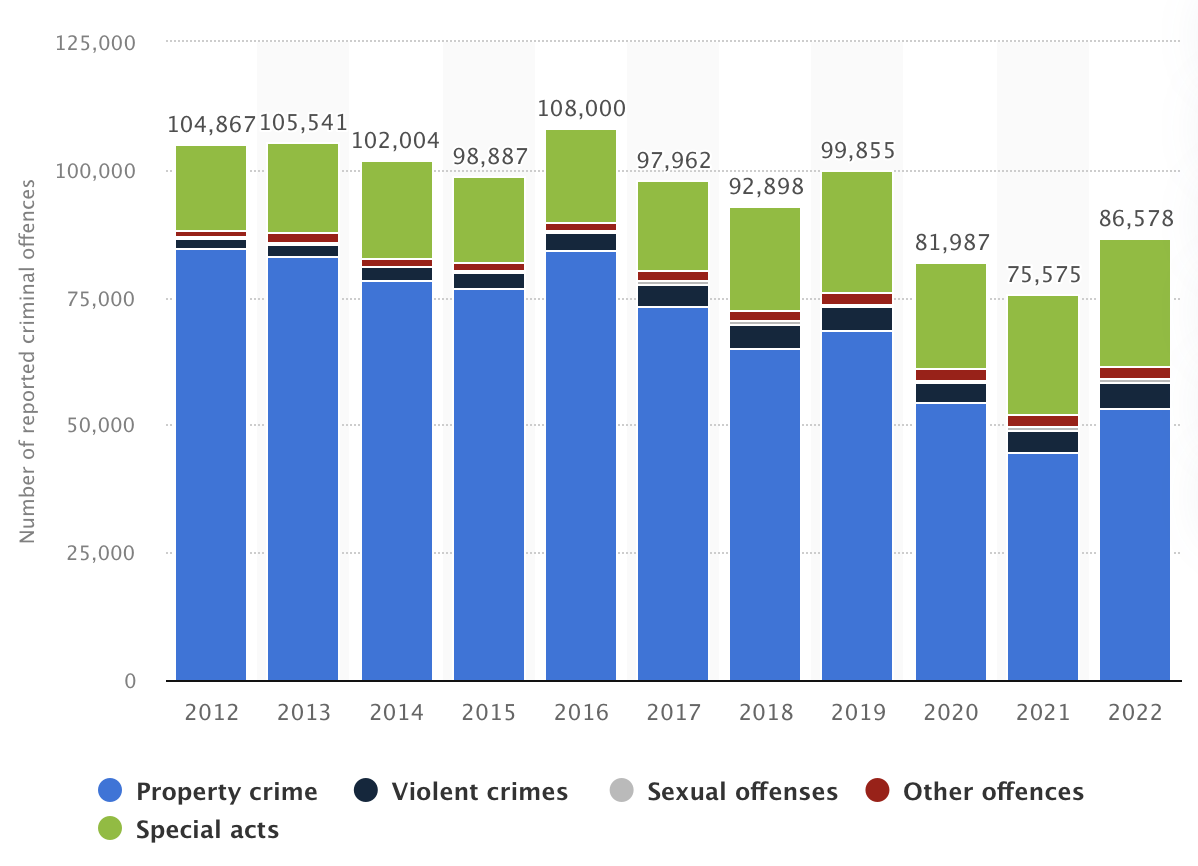

"\nfrom IPython.display import Image\ncpg_statista = 'statista_cpg.png'\npath = f'/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/{cpg_statista}'\nImage(filename=path) #show the picture in the notebook\n"

In [47]:
from IPython.display import Image, display, Markdown


cpg_statista = 'statista_cpg.png'
# Ruta completa al archivo 
path = f'/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/{cpg_statista}'

# Muestra la foto en el notebook con una etiqueta de Markdown como título
display(Markdown("<center><font color='orange'>  Number of reported criminal offences in Copenhagen from 2012 to 2022, by type (from Statista)</font></center>"))
display(Image(filename=path))


"""
from IPython.display import Image
cpg_statista = 'statista_cpg.png'
path = f'/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/{cpg_statista}'
Image(filename=path) #show the picture in the notebook
"""

## 3. Tipos de propiedades y habitaciones

## 3.1 Tipos de habitaciones

Veamos cuantas categorías de tipo de habitación hay disponibles en Copenhague y cuanta es su oferta.

In [ ]:
listings['room_type']. value_counts()

Entire home/apt    16293
Private room        1794
Shared room           28
Hotel room            11
Name: room_type, dtype: int64

In [44]:
import plotly.express as px

freq = listings['room_type'].value_counts().sort_values(ascending=True)

fig = px.bar(freq, orientation='h', color=freq.index, labels={'index': 'Room Type', 'room_type': 'Count'},template= "plotly_dark", log_x=True)

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_xaxes(showgrid=False)

fig.show()


In [64]:
freq = listings['room_type'].value_counts().sort_values(ascending=True)
freq_rtype_percent = (freq / freq.sum()) * 100
freq_rtype_percent

Hotel room          0.060686
Shared room         0.154474
Private room        9.897385
Entire home/apt    89.887454
Name: room_type, dtype: float64

La  mayoría de listings son alquileres de casas/apartamentos/espacios enteros para el huésped. En nuestro caso, no es inconveniente, ya que nuestras clientas prefieren su propio espacio. Aún así, no descartaremos todas las opciones de hoteles.

## 3.2 Tipos de propiedades

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

Hmos seleccionado los tipos de propiedades según los gustos especificados por las clientas en el cuestionario que han respondido previamente. También se han filtrado por capacidad de 2 huéspedes. A continuación se muestra un boxplot con la distribución del rango de precios de la selección mencionada.

In [ ]:
Q1 = listings['price'].quantile(0.25)
Q3 = listings['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stay = [
    'Entire condo', 'Entire loft', 'Entire serviced apartment', 'Private room in bed and breakfast',
    'Room in hostel', 'Entire cabin', 'Tiny home', 'Entire guesthouse', 'Casa particular', 
    'Room in hotel', 'Room in aparthotel', 'Entire vacation home', 'Entire place'
]

filter_stay = listings[listings['property_type'].isin(stay)]
filter_stay['price_capped'] = filter_stay['price'].clip(lower=lower_bound, upper=upper_bound)
for_two = filter_stay[filter_stay['accommodates']==2]

fig6=px.box(for_two, y='property_type', x='price_capped', template='plotly_dark')
fig6.show()



## 4. Review Scores

## 4.1  Resumen de ubicación scores versus precio

En esta sección, agrupamos los puntajes de revisión de la ubicación por vecindario (solo listados con al menos 10 revisiones). Podría ser que la distancia al centro de la ciudad sea un factor importante, así com o la seguridad de la ubicación, el ruido ambiente, disponibilidad de conexiones, proximidad de centros comerciales y disponibilidad de aparcamiento.

Anteriormente, hemos visto que los vecindarios más céntricos eran también los más caros, pero no había diferencias abismales entre los diferentes barrios. También sabemos que no hay barrios considerados zonas peligrosas. Veamos qué correlación presenta la valoración del precio y de la ubicación.

El puntuaje promedio de valoración, está por encima de 4/5 para todos los vecindarios. Copenhague es una ciudad grande, pero muy bien comunicada. Además, es habitual para los daneses desplazarse en bicicleta y la ciudad está muy bien adaptada para ello. Por lo tanto, no lleva mucho tiempo llegar al centro de la ciudad desde cualquier lugar, lo que debe contribuir a los altos promedios. 
Con estas perspectivas, los turistas pueden escojer alojamiento en función de su presupuesto. Ya sea un alojamiento más céntrico y lujoso des de donde se observen las luces del tívoli, o uno más asequible fuera del centro de la ciudad. En ambos estaran seguros y tendran transporte público eficiente o bicicleta.



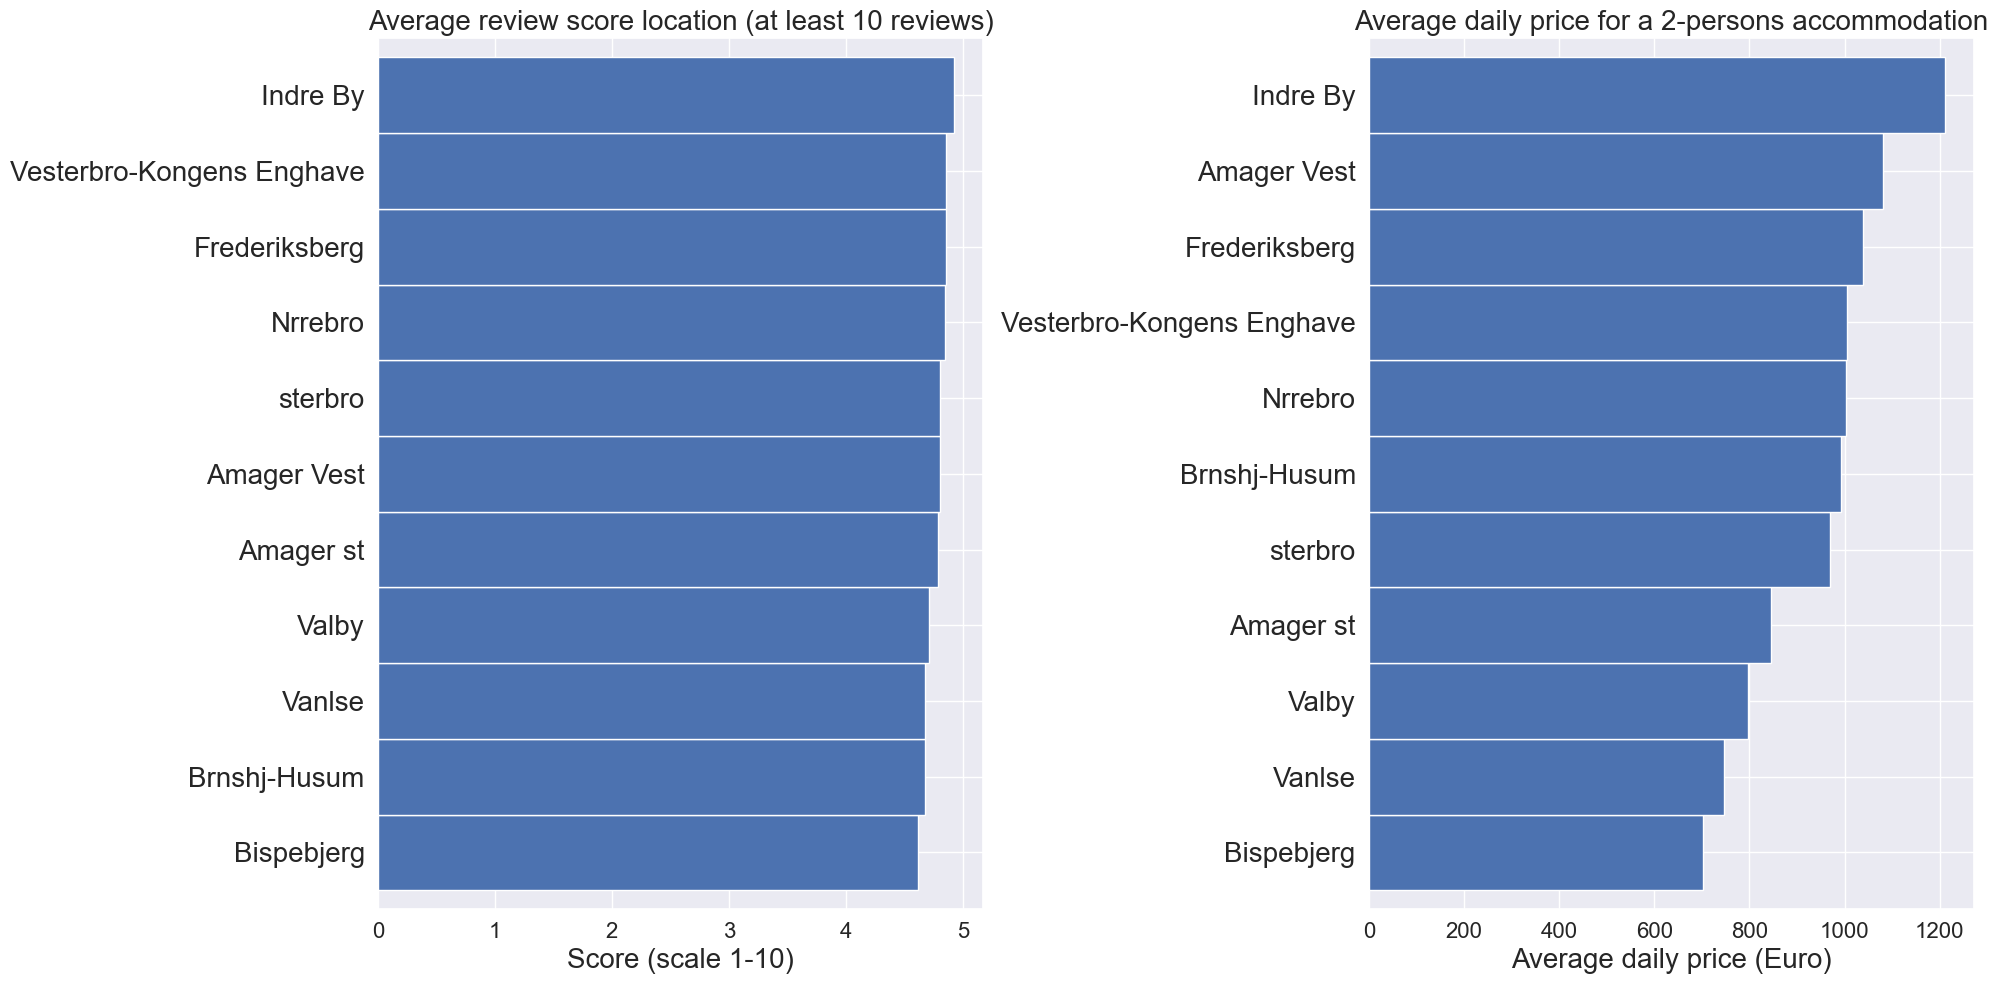

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

## 4.2 Puntuaciones de las opiniones

Además de las reseñas escritas, los huéspedes pueden enviar una calificación de estrellas general y un conjunto de calificaciones de estrellas de categoría. Los huéspedes pueden dar calificaciones sobre:

* Experiencia general. ¿Cuál fue su experiencia en general?
* Limpieza. ¿Sentiste que tu espacio estaba limpio y ordenado?
* Precisión. ¿Con qué precisión su página de listado representó su espacio?
* Valor. ¿Sintió que su listado proporcionó un buen valor por el precio?
* Comunicación. ¿Qué tan bien se comunicó con su anfitrión antes y durante su estadía?
* Llegada. ¿Qué tan bien fue su registro?
* Ubicación. ¿Cómo te sentiste en el barrio?

A continuación puede ver la distribución de puntajes de todas esas categorías. Cabe destacar que no hay ninguna puntuación por debajo de 4 estrellas (de un máximo de 5), aexcepción de la categoría de limpieza.
Vistas las distribuciones de puntajes, se recomienda no aceptar un puntuaje inferior a 4,4.

/var/folders/r3/l5mjc64d2xb46v6tyzc2zcgw0000gn/T/ipykernel_51625/2631385810.py:57: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/r3/l5mjc64d2xb46v6tyzc2zcgw0000gn/T/ipykernel_51625/2631385810.py:58: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/r3/l5mjc64d2xb46v6tyzc2zcgw0000gn/T/ipykernel_51625/2631385810.py:57: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/r3/l5mjc64d2xb46v6tyzc2zcgw0000gn/T/ipykernel_51625/2631385810.py:58: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/r3/l5mjc64d2xb46v6tyzc2zcgw0000gn/T/ipykernel_51625/2631385810.py:57: UserWarning:

set_ticklabels() should only be used with a fixed n

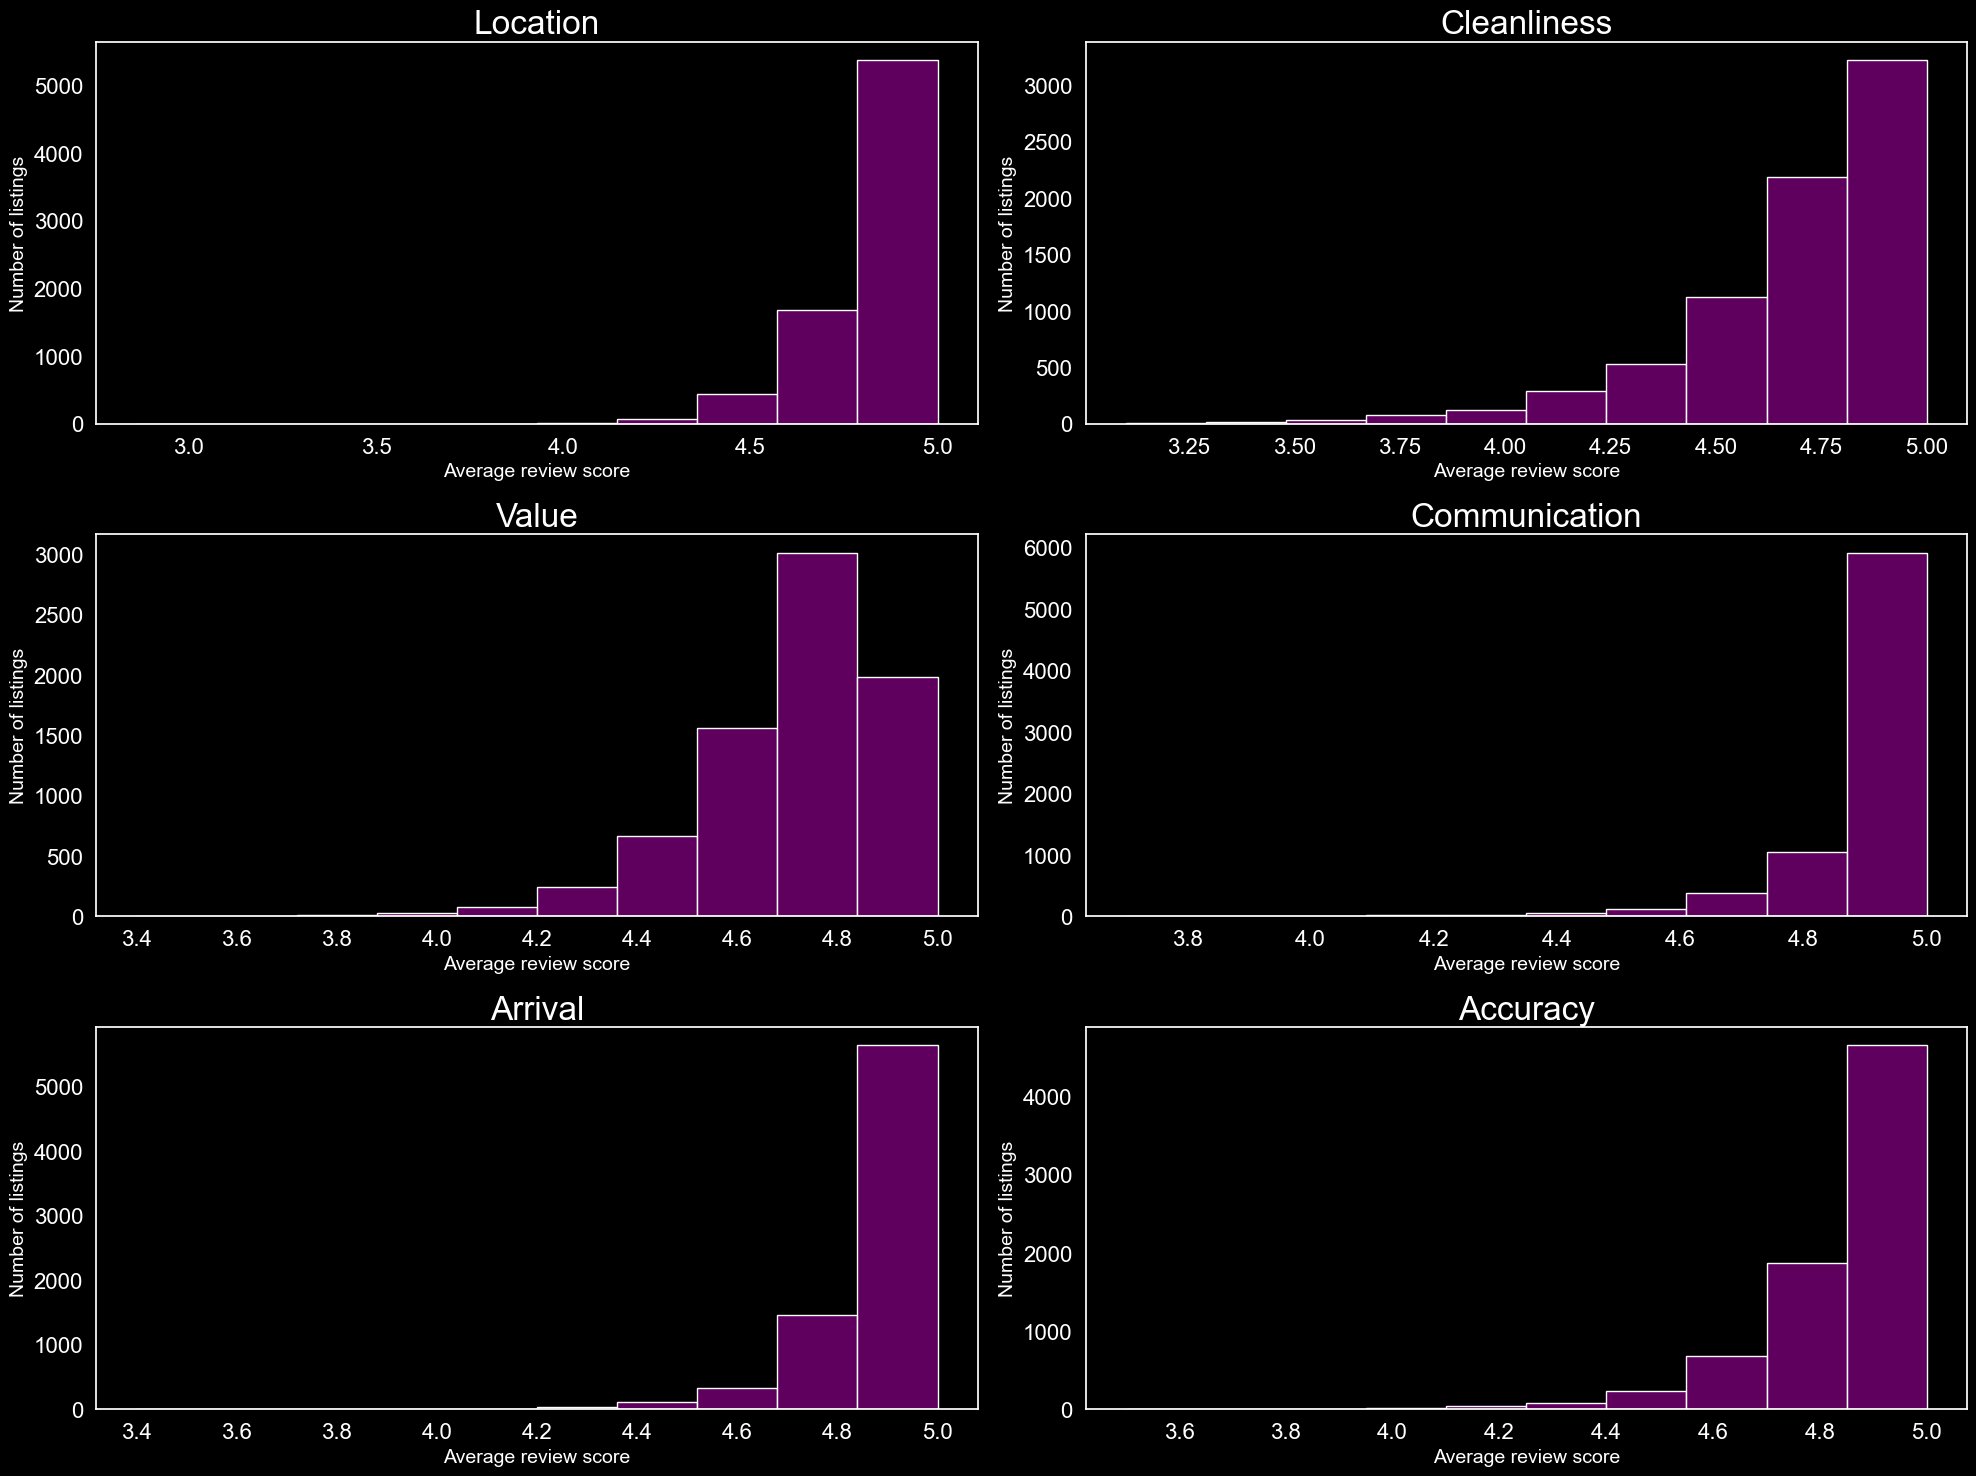

In [48]:

import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar datos
listings10 = listings[listings['number_of_reviews'] >= 10]

# Configurar el estilo de Seaborn
sns.set(style="darkgrid", font_scale=1.2, rc={"axes.grid": False})
sns.set_palette("husl")

# Crear una figura
fig1 = plt.figure(figsize=(20, 15))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Crear subplots
ax1 = fig1.add_subplot(321)
ax2 = fig1.add_subplot(322)
ax3 = fig1.add_subplot(323)
ax4 = fig1.add_subplot(324)
ax5 = fig1.add_subplot(325)
ax6 = fig1.add_subplot(326)

# Colores
color = 'purple'

# Configurar fondos
fig1.patch.set_facecolor('black')
ax1.set_facecolor('black')
ax2.set_facecolor('black')
ax3.set_facecolor('black')
ax4.set_facecolor('black')
ax5.set_facecolor('black')
ax6.set_facecolor('black')

# Crear histogramas
ax1 = sns.histplot(listings10['review_scores_location'], bins=10, color=color, ax=ax1)
ax2 = sns.histplot(listings10['review_scores_cleanliness'], bins=10, color=color, ax=ax2)
ax3 = sns.histplot(listings10['review_scores_value'], bins=10, color=color, ax=ax3)
ax4 = sns.histplot(listings10['review_scores_communication'], bins=10, color=color, ax=ax4)
ax5 = sns.histplot(listings10['review_scores_checkin'], bins=10, color=color, ax=ax5)
ax6 = sns.histplot(listings10['review_scores_accuracy'], bins=10, color=color, ax=ax6)

# Configurar títulos y etiquetas
ax1.set_title("Location", fontsize=24, color='white')
ax2.set_title("Cleanliness", fontsize=24, color='white')
ax3.set_title("Value", fontsize=24, color='white')
ax4.set_title("Communication", fontsize=24, color='white')
ax5.set_title("Arrival", fontsize=24, color='white')
ax6.set_title("Accuracy", fontsize=24, color='white')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_ylabel('Number of listings', fontsize=14, color='white')
    ax.set_xlabel('Average review score', fontsize=14, color='white')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xticklabels(ax.get_xticklabels(), color='white')
    ax.set_yticklabels(ax.get_yticklabels(), color='white')

plt.tight_layout()

# Mostrar el gráfico
plt.show();


## 4.3 Es aconsejable encontrar un SuperHost?

En Airbnb puede encontrarse el estatus de "Superhost". De Airbnb:
* Como SuperAnfitrión, ofrecen una hospitalidad excepcional.
* Obtienen el estatus de SuperAnfitriones auqellos cumplen los siguientes requisitos, los cuales se verifican cada 3 meses:
    * Tienen una calificación general promedio de 4.8 o superior según las reseñas de al menos el 50 % de sus huéspedes de Airbnb durante el último año.
    * Han alojado al menos 10 estadías en el último año o, si realizan reservas a más largo plazo, 100 noches en al menos 3 estadías.
    * No tienen cancelaciones en el último año, a menos que haya circunstancias atenuantes.
    * Responden al 90 % de los mensajes nuevos en 24 horas.

A continuación, podemos ver que solo el **11%** de los listados **para 2 personas** en Copenhague tienen un anfitrión con el estatus Superanfitrión.

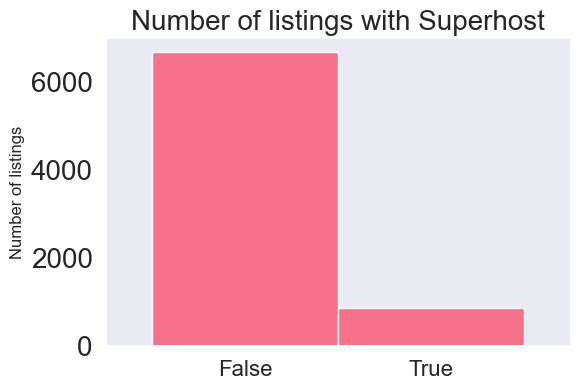

In [62]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})
feq = listings[listings['accommodates'] == 2]['host_is_superhost'].value_counts()


feq.plot.bar(figsize=(6, 4), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

In [59]:
#Porcentaje de superhosts
feq_percent = (feq / feq.sum()) * 100
feq_percent

False    88.592751
True     11.407249
Name: host_is_superhost, dtype: float64

/var/folders/r3/l5mjc64d2xb46v6tyzc2zcgw0000gn/T/ipykernel_51625/3154415133.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/r3/l5mjc64d2xb46v6tyzc2zcgw0000gn/T/ipykernel_51625/3154415133.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



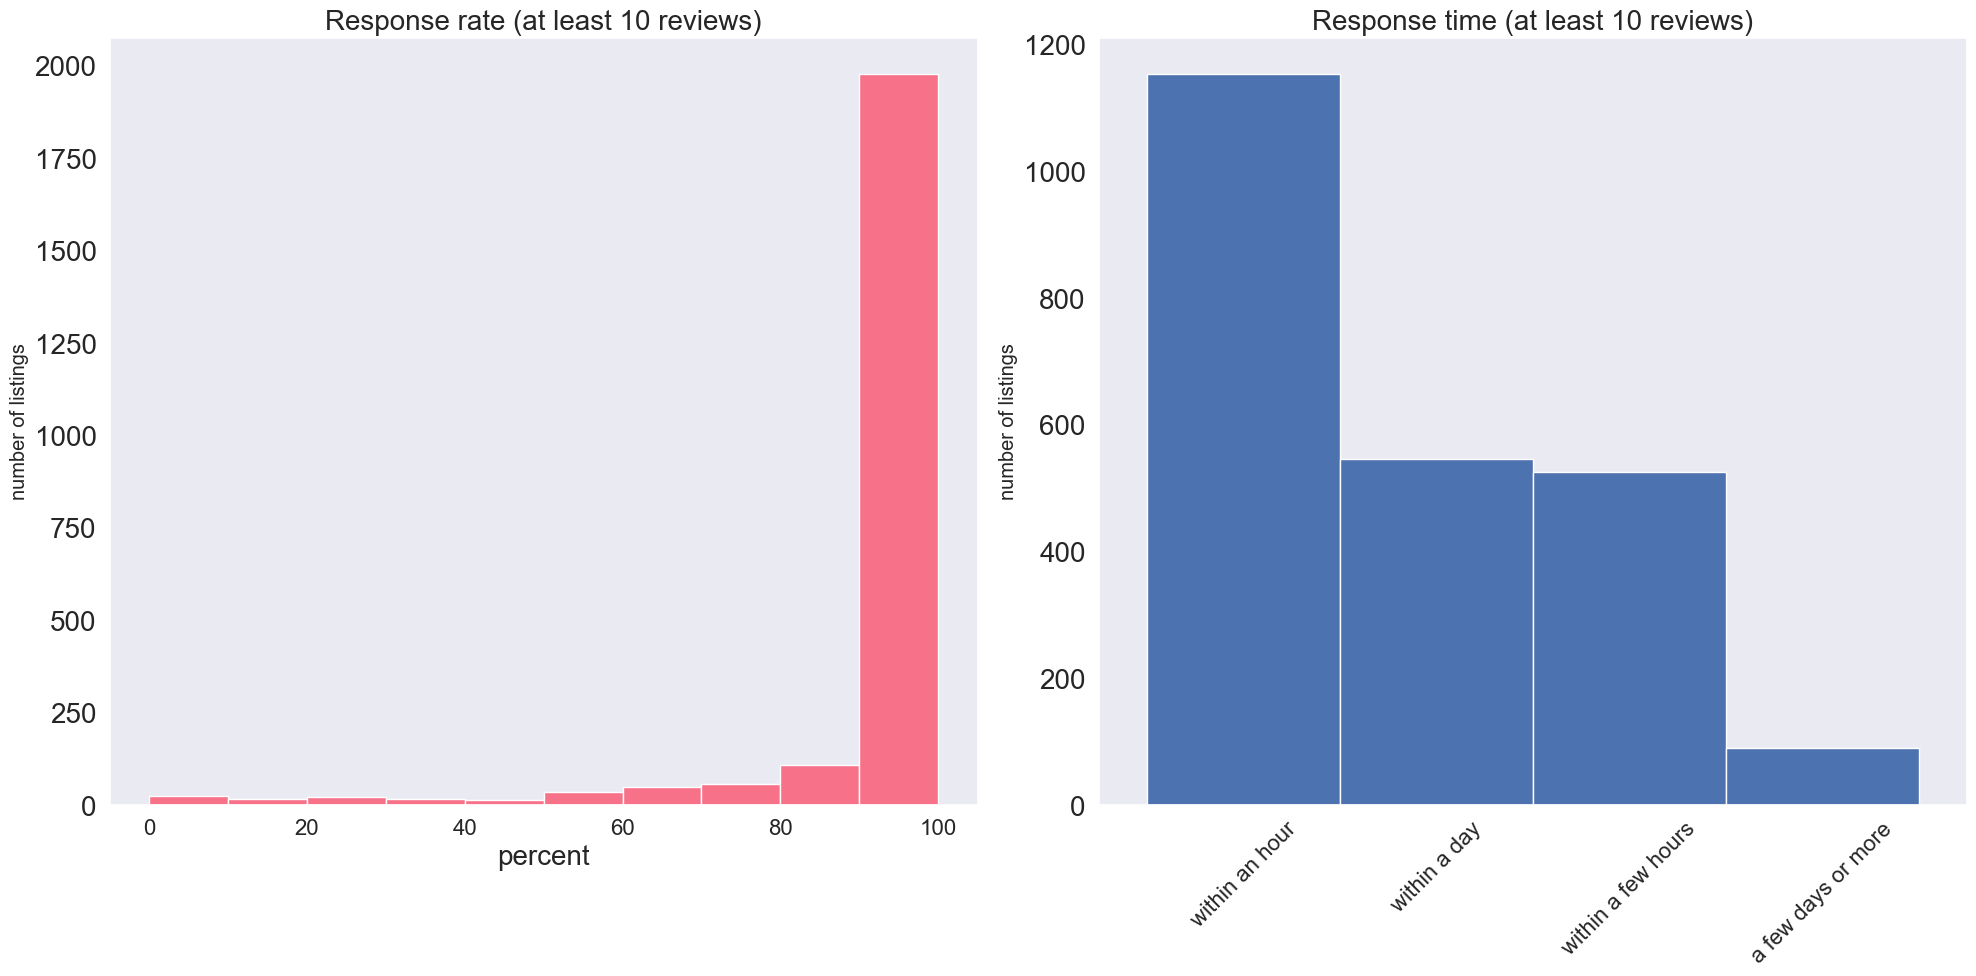

In [54]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10[listings['accommodates'] == 2]['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10[listings['accommodates'] == 2]['host_response_time'].value_counts()

ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

In [65]:
#Porcentaje tiempo de respuesta
feq2 = (listings[listings['accommodates'] == 2]['host_response_time'].value_counts() / len(listings[listings['accommodates'] == 2])) * 100
feq2_percent = (feq2 / feq2.sum()) * 100
feq2_percent

within an hour        43.153685
within a day          27.061512
within a few hours    23.804990
a few days or more     5.979813
Name: host_response_time, dtype: float64

En la ciudad dde Copenhague no parece necesario buscar un SuperAnfitrión. Podría suponer un aumento de precio y no necesariamente ofrecer una experiencia mejor. 

Como podemos ver, el 90% de los anfitriones para 2 personas responden los mensajes nuevos y solo el 4% tarda más de un día en hacerlo. 

Vamos a comprobar si hi hay diferencias de precio entre los host y superhost mediante un test de hipótesis (A/B testing):

In [9]:
from scipy import stats
import seaborn as sns
from scipy.stats import shapiro
import scipy.stats as stats

In [10]:
# Test hipótesis: Representa un SuperHost una diferencia de precio?

# H0: los precios de superhost y host son "iguales"
# H1: los precios de superhost y host son "diferentes"

grupo_A=listings[listings['host_is_superhost']=='f']['price']
grupo_B=listings[listings['host_is_superhost']=='t']['price']

In [11]:
_, p_A = stats.shapiro(grupo_A)
_,p_B =stats.shapiro(grupo_B)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



In [13]:
#així ara ho comprovem amb un altre normal test
_, p_A= stats.normaltest(grupo_A)
_, p_B=stats.normaltest(grupo_B)

print(p_A)
print(p_B)

#Los resultados 0.0, indican qu eno siguen una distribucióno normal.

0.0
0.0


In [14]:
#muestra demasiado grande. vemos si las distribuciones son iguales o no con mannwhitneyu
import scipy.stats as stats
if p_A <0.05 or p_B <0.05:
    _,p_valor = stats.mannwhitneyu(grupo_A,grupo_B) 
    print(f'Tiene un p-valor de {p_valor}')
else:
    _,p_valor = stats.ttest_ind(grupo_A,grupo_B) #podem indicar que la variança és diferent: equal_var=False, si tenim prous dades
    print(f'Tiene un p-valor (por prueba t de dos muestras) de {p_valor}')

Tiene un p-valor de 0.0550815587192859


No podemos rechazar la hipótesis nula. De manera que, podemos afirmar que no

# 5. WordCloud
Veamos ahora cómo podríamos obtener algo de información extra de las opiniones de los usuarios.


In [ ]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

listing_id                                               name  \
id                                                                         
9032126         26057  Home in Copenhagen · ★4.91 · 4 bedrooms · 4 be...   
765464         113508  Rental unit in Frederiksberg · ★4.96 · 2 bedro...   
819978         113508  Rental unit in Frederiksberg · ★4.96 · 2 bedro...   
2060476        113508  Rental unit in Frederiksberg · ★4.96 · 2 bedro...   
572582525      113508  Rental unit in Frederiksberg · ★4.96 · 2 bedro...   

           host_id host_name       date  reviewer_id reviewer_name  \
id                                                                   
9032126     109777      Kari 2013-12-02       582441       Gregory   
765464      577366    Ronnie 2011-12-05       186722         David   
819978      577366    Ronnie 2012-01-01      1402303        Claude   
2060476     577366    Ronnie 2012-08-21      1515991      Jonathan   
572582525   577366    Ronnie 2019-12-03    225628337         Allan   

                                                    comments  
id                                                            
9032126    This is a beautiful house in a beautiful neigh...  
765464     We had an amazing time in CPH. Ronnie's appart...  
819978     The apartment is great, excellent location, al...  
2060476    Ronnie's apartment is the nicest two bedroom a...  
572582525  This was my first AirBnB rental and I have to ...

In [ ]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

"The apartment is great, excellent location, along the lake, walking distance to the museums (Carlsberg Glypotek, National Museum, Design museum) and to the main attractions of the city. The view on the lake couldn't be better.  There is a large living room, lot of light through the large windows, and a large screen (really a home theater) to watch a movie. Just down the house, you can start a 5.3 km walk or run around the lakes. I would definitely recommend this apartment.\r<br/>Claude J\r<br/>"

In [ ]:
#Añadimos ahora algo de preprocesamiento
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/silvia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'apartment great excellent location along lake walking distance museums carlsberg glypotek national museum design museum main attractions city view lake better large living room lot light large windows large screen really home theater watch movie house start km walk run around lakes would definitely recommend apartment br claude j br '

In [ ]:
#Implementar un conteo de palabras y emplearlo para crear un *wordcloud*
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

words  counts
9          the  582009
29         and  554612
69          to  320416
1           is  250646
4           in  249502
101        was  243072
102       very  190673
93          we  177610
64          br  166204
119  apartment  145586

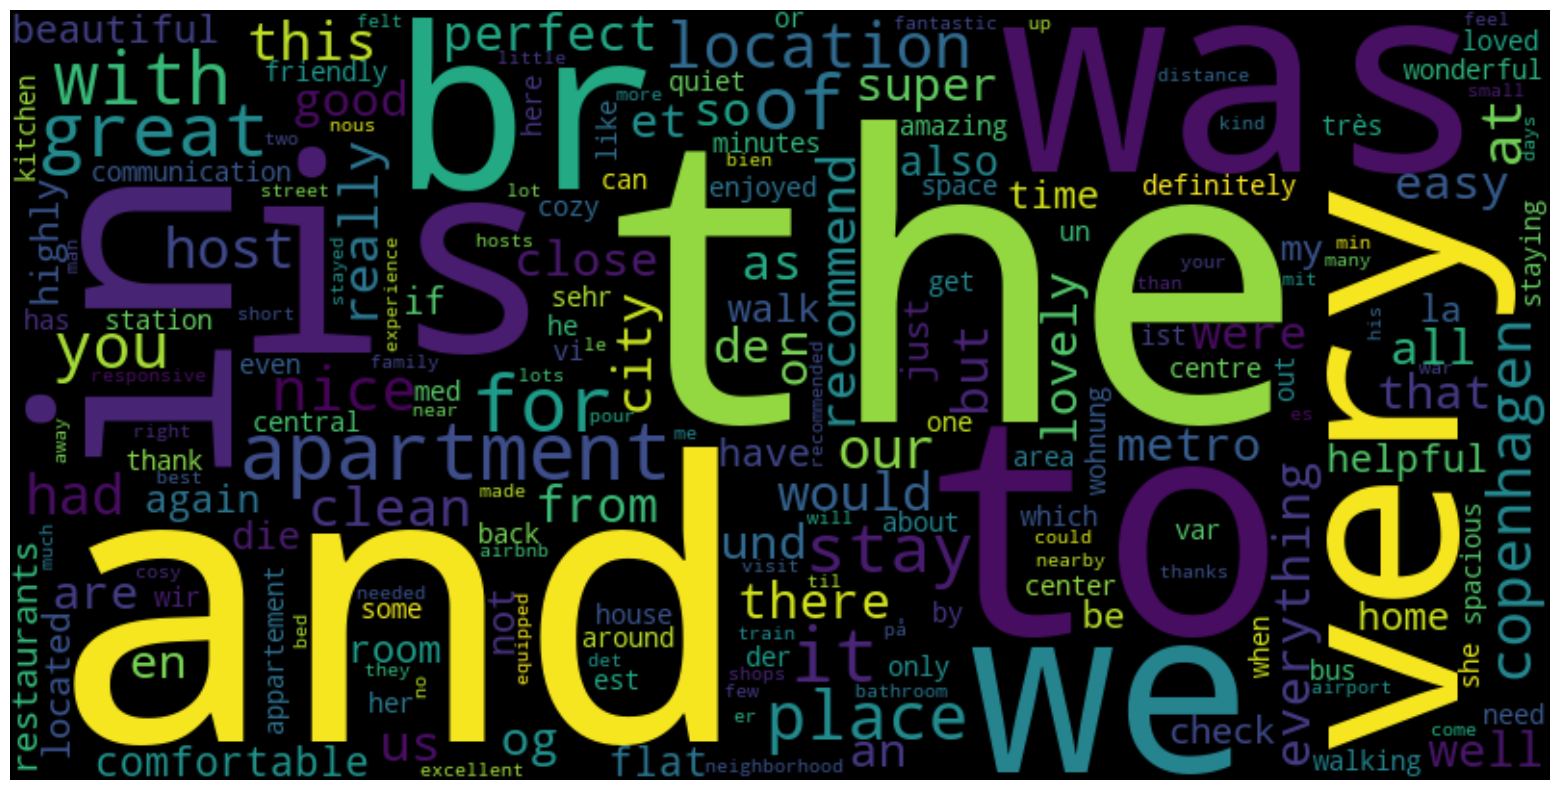

In [ ]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#es pot utilizar com a portada

## 6. Annexo
En este apartado se encuentran operaciones técnicas realizadas para exportar los datasets a PowerBI.
Así como el aporte de infromación extra considerada atractiva para las clientas.

* df_alert: contiene 3 ubicaciones, no consideradas peligrosas pero donde deben tener cuidado.
* df_cbun: continene las ubicaciones de diversas panaderías consideradas favoritas para la ciudad de Copenhague. Dónde nuestras clientas pueden parar a catar los bollos de canela tan populares de los países escandinavos. Así, en cualquier momento del día pueden mirar cuál les queda más cerca, hacer un descanso y reponer fuerzas.

guardo calendar como csv por si lo necesito en powerBI


In [ ]:
#calendar.to_csv('calendar.csv', index=True)

leemos el archivo excel con ubicaciones interesantes para el cliente

In [ ]:
df_alert=pd.read_excel('/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/lat_long.xlsx', sheet_name=0)
df_cbun=pd.read_excel('/Users/silvia/Desktop/Upgrade hub/Proyecto_modulo2/lat_long.xlsx', sheet_name=1)

In [ ]:
df_cbun.drop(0,axis=0, inplace=True)

In [ ]:
#df_alert.to_csv('alert.csv', index=True)
#df_cbun.to_csv('cbun.csv', index=True)

## 6.1 Turismo en bicicleta

En este apartado se proponen 4 recorridos por la ciudad de Copenhague. Sabemos que nuestras clientas son activas y quieren hacer actividades juntas mientras se camuflan entre los propios daneses. ¿Qué mejor que descubrir la ciudad en bicicleta?!

In [36]:
import geopandas as gpd
import folium
from folium import plugins

# Cargar los archivos GeoJSON
green_cope = gpd.read_file("cyclo_tourism/from_green_copenhagen_to_downtown_copenhagen.geojson")
kobenhavn=gpd.read_file("cyclo_tourism/kobenhavn.geojson")
christiania= gpd.read_file("cyclo_tourism/kopenhage_chistiania.geojson")
paseo=gpd.read_file("cyclo_tourism/paseo_copenhague.geojson")

# Crear un mapa centrado en Copenhague
mapa_rutas = folium.Map(location=[55.6759, 12.5655], zoom_start=12)

# Definir una paleta de colores
colors = ['blue', 'yellow', 'red', 'purple']

# Agregar rutas al mapa
for idx, gdf in enumerate([green_cope, kobenhavn, christiania, paseo]):
    gjson = gdf.to_crs(epsg=4326).to_json()
    folium.GeoJson(data=gjson,
                   style_function=lambda feature, color=colors[idx]: {
                       'color': color,
                       'weight': 5
                   },
                   name=gdf['name'].iloc[0]).add_to(mapa_rutas)

# Añadir control de capas
folium.LayerControl().add_to(mapa_rutas)

# Guardar el mapa en un archivo HTML

mapa_rutas

Voy a poner todas las rutas en un CSV.

In [38]:
#------------> GREEN_COPE

import json
import pandas as pd

# Carga el archivo GeoJSON green_cope:

with open("cyclo_tourism/from_green_copenhagen_to_downtown_copenhagen.geojson", 'r') as file:
    data = json.load(file)

# Inicializa listas para almacenar los datos
latitudes = []
longitudes = []
spatial_data = []

# Recorre las características (features) en el archivo GeoJSON
for feature in data['features']:
    geometry = feature['geometry']
    if geometry['type'] == 'MultiLineString':
        # Para cada coordenada en MultiLineString
        for coordinates in geometry['coordinates'][0]:
            latitude, longitude, spatial = coordinates
            latitudes.append(latitude)
            longitudes.append(longitude)
            spatial_data.append(spatial)

# Crea un DataFrame de Pandas
green_cope = pd.DataFrame({'Latitud': latitudes, 'Longitud': longitudes, 'Spatial': spatial_data})

#Creamos una columna llamada "ruta" con el nombre de la ruta:
green_cope['Route'] = 'green_cope'

# Muestra las primeras filas de la tabla
print(green_cope.head())


     Latitud   Longitud  Spatial       Route
0  12.493258  55.693612   15.033  green_cope
1  12.490876  55.693290   15.023  green_cope
2  12.488580  55.692855   16.015  green_cope
3  12.486305  55.692424   16.007  green_cope
4  12.484031  55.691940   16.096  green_cope


In [39]:
#------------> KOBENHAVN

import json
import pandas as pd

# Carga el archivo GeoJSON kobenhaven:

with open("cyclo_tourism/kobenhavn.geojson", 'r') as file:
    data = json.load(file)

# Inicializa listas para almacenar los datos
latitudes = []
longitudes = []
spatial_data = []

# Recorre las características (features) en el archivo GeoJSON
for feature in data['features']:
    geometry = feature['geometry']
    if geometry['type'] == 'MultiLineString':
        # Para cada coordenada en MultiLineString
        for coordinates in geometry['coordinates'][0]:
            latitude, longitude, spatial = coordinates
            latitudes.append(latitude)
            longitudes.append(longitude)
            spatial_data.append(spatial)

# Crea un DataFrame de Pandas
kobenhavn= pd.DataFrame({'Latitud': latitudes, 'Longitud': longitudes, 'Spatial': spatial_data})

#Creamos una columna llamada "ruta" con el nombre de la ruta:
kobenhavn['Route'] = 'kobenhavn'

# Muestra las primeras filas de la tabla
print(kobenhavn.head())


     Latitud   Longitud  Spatial      Route
0  12.558763  55.667349   42.799  kobenhavn
1  12.559281  55.666996   31.707  kobenhavn
2  12.558468  55.667297   27.227  kobenhavn
3  12.559161  55.667188   34.007  kobenhavn
4  12.558526  55.667371   30.374  kobenhavn


In [40]:
#------------> chistiania

import json
import pandas as pd

# Carga el archivo GeoJSON green_cope:

with open("cyclo_tourism/kopenhage_chistiania.geojson", 'r') as file:
    data = json.load(file)

# Inicializa listas para almacenar los datos
latitudes = []
longitudes = []
spatial_data = []

# Recorre las características (features) en el archivo GeoJSON
for feature in data['features']:
    geometry = feature['geometry']
    if geometry['type'] == 'MultiLineString':
        # Para cada coordenada en MultiLineString
        for coordinates in geometry['coordinates'][0]:
            latitude, longitude, spatial = coordinates
            latitudes.append(latitude)
            longitudes.append(longitude)
            spatial_data.append(spatial)

# Crea un DataFrame de Pandas
chistiania = pd.DataFrame({'Latitud': latitudes, 'Longitud': longitudes, 'Spatial': spatial_data})

#Creamos una columna llamada "ruta" con el nombre de la ruta:
chistiania['Route'] = 'chistiania'

# Muestra las primeras filas de la tabla
print(chistiania.head())


     Latitud   Longitud  Spatial       Route
0  12.559875  55.684558   44.089  chistiania
1  12.558078  55.682638   45.006  chistiania
2  12.558070  55.682451   47.026  chistiania
3  12.559755  55.682031   43.008  chistiania
4  12.560583  55.681249   43.019  chistiania


In [41]:
#------------> paseo

import json
import pandas as pd

# Carga el archivo GeoJSON green_cope:

with open("cyclo_tourism/paseo_copenhague.geojson", 'r') as file:
    data = json.load(file)

# Inicializa listas para almacenar los datos
latitudes = []
longitudes = []
spatial_data = []

# Recorre las características (features) en el archivo GeoJSON
for feature in data['features']:
    geometry = feature['geometry']
    if geometry['type'] == 'MultiLineString':
        # Para cada coordenada en MultiLineString
        for coordinates in geometry['coordinates'][0]:
            latitude, longitude, spatial = coordinates
            latitudes.append(latitude)
            longitudes.append(longitude)
            spatial_data.append(spatial)

# Crea un DataFrame de Pandas
paseo = pd.DataFrame({'Latitud': latitudes, 'Longitud': longitudes, 'Spatial': spatial_data})

#Creamos una columna llamada "ruta" con el nombre de la ruta:
paseo['Route'] = 'paseo'

# Muestra las primeras filas de la tabla
print(paseo.head())

     Latitud   Longitud  Spatial  Route
0  12.540935  55.681997  -31.675  paseo
1  12.542447  55.682542  -34.728  paseo
2  12.544268  55.683967  -24.820  paseo
3  12.545377  55.685837  -17.408  paseo
4  12.545280  55.686642  -28.418  paseo


In [42]:
# Combinar los DataFrames en uno solo
bike_routes = pd.concat([green_cope, kobenhavn, chistiania, paseo], ignore_index=True)

bike_routes


Latitud   Longitud  Spatial       Route
0    12.493258  55.693612   15.033  green_cope
1    12.490876  55.693290   15.023  green_cope
2    12.488580  55.692855   16.015  green_cope
3    12.486305  55.692424   16.007  green_cope
4    12.484031  55.691940   16.096  green_cope
..         ...        ...      ...         ...
918  12.534833  55.681048   -4.523       paseo
919  12.538173  55.681255    4.571       paseo
920  12.540840  55.681745   14.281       paseo
921  12.543238  55.681273    3.964       paseo
922  12.543893  55.681317   -0.528       paseo

[923 rows x 4 columns]

In [43]:
#bike_routes.to_csv('bike.csv', index=True)